In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os

In [374]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'examples/deconv_deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB


In [375]:
# set net to batch size of 50
net.blobs['data'].reshape(1,3,227,227)
#[(k, v.data.shape) for k, v in net.blobs.items()]

In [401]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/dog1.jpg'))

In [377]:
net.params["conv1t"][0].data[...] = net.params["conv1"][0].data.transpose(0,1,3,2)
net.params["conv2t"][0].data[...] = net.params["conv2"][0].data.transpose(0,1,3,2)
net.params["conv3t"][0].data[...] = net.params["conv3"][0].data.transpose(0,1,3,2)
net.params["conv4t"][0].data[...] = net.params["conv4"][0].data.transpose(0,1,3,2)
net.params["conv5t"][0].data[...] = net.params["conv5"][0].data.transpose(0,1,3,2)
print net.params['conv1t'][0].data.shape, net.params['conv1'][0].data.shape

(96, 3, 11, 11) (96, 3, 11, 11)


In [383]:

## reconstruct from conv3
# First find the top 9 activations of conv3, then zero out other activations
# and then use one of several of the 9 activations to reconstruct an image
oo = net.forward(end = "conv3t")
print net.blobs['conv3'].data[0].shape
d = net.blobs['conv3'].data[0].copy()
d = d.reshape(64896)
indices = np.argsort(d)
ind = indices[-9:]
print indices[-9:], net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13]

(384, 13, 13)
[28227 55920 40605 58642 55917 46136  5082 48211 39733] [ 215.1869812   217.49874878  217.66891479  222.834198    227.35635376
  228.67471313  231.19174194  234.60951233  254.4641571 ]


In [384]:
keep = net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13]
net.blobs['conv3'].data[...] = 0
i = 7
net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13] = keep
#net.blobs['conv3'].data[0][ind[i]//169, (ind[i]%169)//13, ind[i]%169%13] = keep[i]
print net.blobs['conv3'].data[0][ind//169, (ind%169)//13, ind%169%13]
ii = net.blobs['conv3'].data[0] != 0

[ 215.1869812   217.49874878  217.66891479  222.834198    227.35635376
  228.67471313  231.19174194  234.60951233  254.4641571 ]


In [426]:
## reconstruct from pool5
# First find the top 9 activations of pool5, then zero out other activations
# and then use one of several of the 9 activations to reconstruct an image
oo = net.forward(end = "unpool5")
print net.blobs['pool5'].data[0].shape
d = net.blobs['pool5'].data[0].copy()
d = d.reshape(9216)
indices = np.argsort(d)
ind = indices[-9:]
print indices[-9:], net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6], net.blobs['pool5_mask'].data[0][ind//36, (ind%36)//6, ind%36%6]

(256, 6, 6)
[6192 7029 7035 4653 4654 5414 5415 4660 4659] [  98.15696716  103.80316925  103.80316925  104.21897888  104.21897888
  112.35114288  112.62605286  127.29307556  127.29307556] [ 14.  59.  59.  60.  60.  71.  72.  73.  73.]


In [427]:
keep = net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6]
net.blobs['pool5'].data[...] = 0
i = 7
# net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6] = keep
net.blobs['pool5'].data[0][ind[i]//36, (ind[i]%36)//6, ind[i]%36%6] = keep[i]
print net.blobs['pool5'].data[0][ind//36, (ind%36)//6, ind%36%6] 
ii = net.blobs['pool5'].data[0] != 0

[   0.            0.            0.            0.            0.            0.
    0.          127.29307556    0.        ]


In [428]:
out = net.forward(start='unpool5')

In [402]:
#filters = net.params["conv5"][0].data.copy()
#net.params["conv5"][0].data[...] = 0
#net.params["conv5"][0].data[0] = filters[0]

#out = net.forward()
#ii = net.blobs['pool5'].data[0] != 0
#da = net.blobs['conv3t'].data[0][net.blobs['conv3t'].data[0]!=0] 
#print da

In [429]:
print net.blobs['unpool5'].data[0].max()
o = net.blobs['conv1t'].data[0].copy()
print o.shape
o -= o.min()
o /= o.max()
o *= 255
o = np.rollaxis(o, 0, 3)

print o.shape


127.293
(3, 227, 227)
(227, 227, 3)


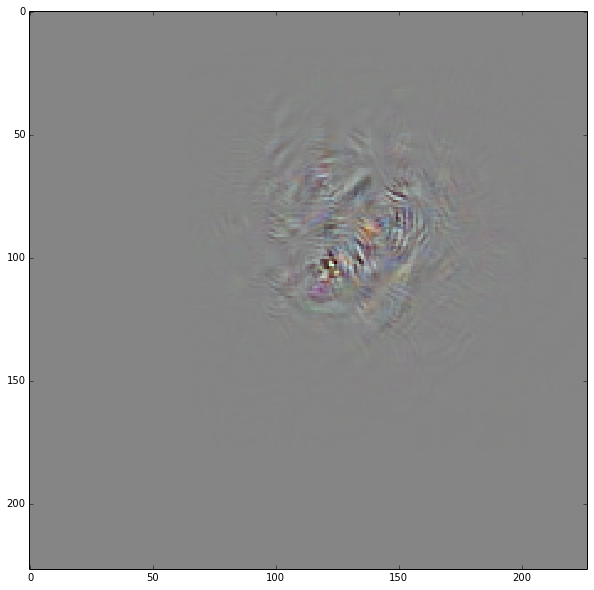

In [431]:
plt.imshow(o.astype(np.uint8))
plt.savefig(caffe_root + 'examples/images/dog1_pool5_one.jpg')

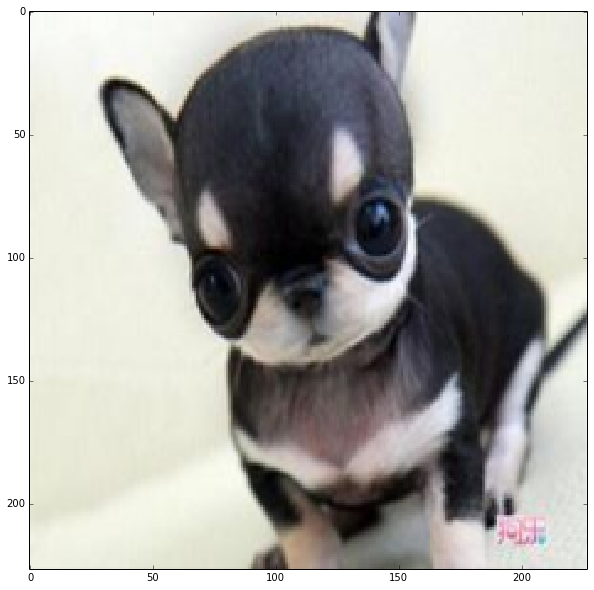

In [425]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))
#plt.savefig(caffe_root + 'examples/images/dog1_wrapped.jpg')